# ==============================================================================
# IMPOR LIBRARY & KONFIGURASI
# ==============================================================================

In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory # Untuk stopwords default Sastrawi jika file tidak ada
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler # Untuk custom features numerik jika digabung
from scipy.sparse import hstack # Untuk menggabungkan matriks sparse
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # Untuk menyimpan model

print("Library dasar dan lanjutan berhasil diimpor.")

# --- Konfigurasi Global ---
DATASET_PATH = '../../dataset/dataset_spam_nlp.csv'
SLANG_FILE_PATH = '../../dataset/slang_indo.csv' 
STOPWORDS_FILE_PATH = '../.. v/dataset/stopwords-id.txt'
RANDOM_STATE_SEED = 42
TEST_SET_SIZE = 0.2
# Opsi untuk stemming, bisa diubah menjadi True untuk mengaktifkan
PERFORM_STEMMING_DEFAULT = False 
# Opsi untuk SMOTE (akan diimplementasikan jika diperlukan dan diputuskan)
# USE_SMOTE = False 

print(f"Konfigurasi: DATASET_PATH='{DATASET_PATH}', STEMMING={PERFORM_STEMMING_DEFAULT}")

Library dasar dan lanjutan berhasil diimpor.
Konfigurasi: DATASET_PATH='../../dataset/dataset_spam_nlp.csv', STEMMING=False


# ==============================================================================
# FUNGSI-FUNGSI PEMBANTU (HELPER FUNCTIONS)
# ==============================================================================

In [7]:
# --- 2.1. Persiapan Alat Preprocessing ---
def setup_preprocessing_tools(slang_file_path, stopwords_file_path):
    slang_dict = {}
    try:
        slang_df = pd.read_csv(slang_file_path, header=None, names=['slang', 'formal'], sep=',')
        slang_dict = dict(zip(slang_df['slang'], slang_df['formal']))
        print(f"Kamus slang berhasil dimuat dari '{slang_file_path}'. Jumlah entri: {len(slang_dict)}")
    except FileNotFoundError:
        print(f"Peringatan: File kamus slang '{slang_file_path}' tidak ditemukan.")
    except Exception as e:
        print(f"Peringatan: Gagal memuat kamus slang. Error: {e}")
    
    additional_slang = {
        'yg': 'yang', 'dg': 'dengan', 'rt': 'rumah tangga', 'utk': 'untuk', 'cuman': 'cuma', 
        'gini': 'begini', 'gitu': 'begitu', 'tdk': 'tidak', 'ga': 'tidak', 'gak': 'tidak', 
        'nggak': 'tidak', 'gk': 'tidak', 'dr': 'dari', 'dlm': 'dalam', 'jd': 'jadi', 
        'jgn': 'jangan', 'sdh': 'sudah', 'blm': 'belum', 'bgt': 'banget', 'jg': 'juga', 
        'lg': 'lagi', 'sm': 'sama', 'tp': 'tapi', 'udah': 'sudah', 'sy': 'saya', 
        'aq': 'aku', 'gw': 'gue', 'gua': 'gue', 'klo': 'kalau', 'kalo': 'kalau', 
        'emg': 'memang', 'dgn': 'dengan', 'skrg': 'sekarang', 'bnyk': 'banyak', 
        'byk': 'banyak', 'tdr': 'tidur', 'mkn': 'makan', 'min': 'admin',
        'wkwk': '', 'wkwkwk': '', 'haha': '', 'hehe': ''
    }
    slang_dict.update(additional_slang)

    stopwords_set = set()
    try:
        with open(stopwords_file_path, 'r', encoding='utf-8') as f:
            stopwords_set = set(f.read().splitlines())
        print(f"Daftar stopwords berhasil dimuat dari '{stopwords_file_path}'. Jumlah: {len(stopwords_set)}")
    except FileNotFoundError:
        print(f"Peringatan: File stopwords '{stopwords_file_path}' tidak ditemukan. Menggunakan stopwords default Sastrawi jika tersedia.")
        try:
            remover_factory = StopWordRemoverFactory()
            stopwords_set = set(remover_factory.get_stop_words())
            print(f"Menggunakan stopwords default Sastrawi. Jumlah: {len(stopwords_set)}")
        except Exception as e_sastrawi:
            print(f"Gagal memuat stopwords default Sastrawi: {e_sastrawi}")
    except Exception as e:
        print(f"Peringatan: Gagal memuat stopwords. Error: {e}")
        
    stemmer = None
    try:
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        print("Stemmer Sastrawi berhasil dibuat.")
    except Exception as e:
        print(f"Peringatan: Gagal membuat stemmer Sastrawi. Error: {e}.")
        
    text_patterns_to_remove = [
        r"\(cont\)", r"lanjutkan", r"lihat selengkapnya", r"see more",
    ]
    regex_text_patterns = re.compile(r'|'.join(text_patterns_to_remove), re.IGNORECASE)

    return slang_dict, stopwords_set, stemmer, regex_text_patterns

# --- 2.2. Fungsi Preprocessing Teks ---
def preprocess_text(text, slang_dict, stopwords_set, stemmer, regex_text_patterns, perform_stemming=True):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    
    text_processed = str(text).lower().strip()
    text_processed = re.sub(r'@\w+|#\w+', ' ', text_processed) # Hapus mention dan hashtag
    text_processed = re.sub(r'http\S+|www\S+|https\S+', ' ', text_processed, flags=re.MULTILINE) # Hapus URL
    text_processed = regex_text_patterns.sub(' ', text_processed) # Hapus pola teks spesifik
    text_processed = re.sub(r'[^a-z\s]', ' ', text_processed) # Hanya pertahankan huruf dan spasi (hapus angka & tanda baca)
    
    words = text_processed.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    text_processed = " ".join(normalized_words)
    
    words = text_processed.split()
    words = [word for word in words if word not in stopwords_set and len(word) > 1]
    text_processed = " ".join(words)
    
    if perform_stemming and stemmer:
        try:
            text_processed = stemmer.stem(text_processed)
        except Exception:
            pass # Abaikan error stemming untuk satu teks tertentu
            
    text_processed = re.sub(r'\s+', ' ', text_processed).strip()
    return text_processed

# --- 2.3. Fungsi Ekstraksi Custom Features ---
def extract_custom_features(text_series_raw):
    """
    Mengekstrak custom features dari series teks mentah.
    Mengacu pada fitur-fitur di presennn.pdf.
    """
    df_features = pd.DataFrame()

    # Fitur dari presennn.pdf [cite: 1]
    df_features['text_length'] = text_series_raw.apply(lambda x: len(str(x))) # [cite: 6]
    df_features['word_count'] = text_series_raw.apply(lambda x: len(str(x).split())) # [cite: 6]
    df_features['avg_word_length'] = df_features['text_length'] / (df_features['word_count'] + 1e-6) # [cite: 6]
    
    df_features['uppercase_ratio'] = text_series_raw.apply(lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1e-6)) # [cite: 6]
    df_features['question_marks'] = text_series_raw.apply(lambda x: str(x).count('?')) # [cite: 6]
    df_features['exclamation_marks'] = text_series_raw.apply(lambda x: str(x).count('!')) # [cite: 6]
    
    # Menggunakan regex untuk deteksi URL yang lebih baik
    df_features['url_count'] = text_series_raw.apply(lambda x: len(re.findall(r'http\S+|www\S+|https\S+', str(x)))) # [cite: 6]
    df_features['has_url'] = df_features['url_count'] > 0 # [cite: 6]
    
    # Fitur pengulangan karakter (contoh sederhana)
    def count_char_repetition(text): # [cite: 6]
        text = str(text)
        count = 0
        for char_code in range(ord('a'), ord('z') + 1):
            char = chr(char_code)
            if re.search(f'{char}{{5,}}', text.lower()): # Pengulangan 5 kali atau lebih [cite: 6]
                count += 1
        return count
    df_features['char_repetition_gte5'] = text_series_raw.apply(count_char_repetition) # [cite: 6]
    
    # Fitur keberadaan pertanyaan (lebih dari sekadar tanda tanya)
    question_words = ['apa', 'siapa', 'kapan', 'dimana', 'mengapa', 'bagaimana', 'berapa', 'kah'] # [cite: 7]
    df_features['has_question_word'] = text_series_raw.apply(lambda x: any(word in str(x).lower() for word in question_words) or ('?' in str(x))) # [cite: 7]

    # Fitur kata-kata hiperbolik/promosi (contoh sederhana)
    hyperbolic_keywords = ['gratis', 'promo', 'diskon', 'cepat', 'mudah', 'terbaik', 'dijamin', 'untung', 'bonus', 'wajib'] # [cite: 7]
    df_features['hyperbolic_word_count'] = text_series_raw.apply(lambda x: sum(1 for word in hyperbolic_keywords if word in str(x).lower())) # [cite: 7]

    # Fitur kata perintah/imperatif (contoh sederhana)
    imperative_keywords = ['klik', 'daftar', 'beli', 'pesan', 'kunjungi', 'download', 'ambil', 'cek'] # [cite: 7]
    df_features['imperative_count'] = text_series_raw.apply(lambda x: sum(1 for word in imperative_keywords if word in str(x).lower())) # [cite: 7]

    # Fitur indikasi gibberish (kata tanpa vokal >= 5 huruf)
    def contains_gibberish(text): # [cite: 8]
        words = str(text).lower().split()
        for word in words:
            if len(word) >= 5 and not re.search(r'[aeiou]', word): # [cite: 8]
                return True
        return False
    df_features['contains_gibberish'] = text_series_raw.apply(contains_gibberish) # [cite: 8]

    print(f"Custom features berhasil diekstrak. Shape: {df_features.shape}")
    return df_features.astype(float) # Pastikan semua fitur numerik

# --- 2.4. Fungsi Evaluasi Model ---
def evaluate_model(model_name, y_true, y_pred, target_names):
    print(f"\n--- Evaluasi untuk Model: {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Label Aktual')
    plt.xlabel('Label Prediksi')
    plt.show()

# ==============================================================================
# FUNGSI PIPELINE UTAMA
# ==============================================================================

In [8]:
def run_classification_pipeline():
    print("--- MEMULAI PIPELINE DETEKSI SPAM MULTIKELAS ---")

    # --- 1. Pemuatan dan Persiapan Data Awal ---
    print("\n[Tahap 1] Pemuatan & Persiapan Data...")
    try:
        df = pd.read_csv(DATASET_PATH)
    except FileNotFoundError:
        print(f"ERROR: Dataset '{DATASET_PATH}' tidak ditemukan.")
        return
    
    if 'ulasan' not in df.columns or 'kategori' not in df.columns:
        print("ERROR: Kolom 'ulasan' dan 'kategori' tidak ditemukan di dataset.")
        return
    df.dropna(subset=['ulasan', 'kategori'], inplace=True) # Hapus baris jika ada NaN di kolom penting

    label_encoder = LabelEncoder()
    df['kategori_encoded'] = label_encoder.fit_transform(df['kategori'])
    label_mapping = {i: class_name for i, class_name in enumerate(label_encoder.classes_)}
    print("Pemetaan Label:", label_mapping)

    X_raw = df['ulasan']
    y = df['kategori_encoded']

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_raw, y, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE_SEED, stratify=y
    )
    print(f"Data dibagi: {len(X_train_raw)} latih, {len(X_test_raw)} uji.")

    # --- 2. Persiapan Alat Preprocessing ---
    print("\n[Tahap 2] Menyiapkan Alat Preprocessing...")
    slang_map, stopwords_set, sastrawi_stemmer, regex_patterns = setup_preprocessing_tools(SLANG_FILE_PATH, STOPWORDS_FILE_PATH)

    # --- 3. Preprocessing Teks ---
    print("\n[Tahap 3] Preprocessing Teks...")
    print(f"Preprocessing X_train_raw (stemming={PERFORM_STEMMING_DEFAULT})...")
    X_train_processed = X_train_raw.apply(
        lambda text: preprocess_text(text, slang_map, stopwords_set, sastrawi_stemmer, regex_patterns, PERFORM_STEMMING_DEFAULT)
    )
    print(f"Preprocessing X_test_raw (stemming={PERFORM_STEMMING_DEFAULT})...")
    X_test_processed = X_test_raw.apply(
        lambda text: preprocess_text(text, slang_map, stopwords_set, sastrawi_stemmer, regex_patterns, PERFORM_STEMMING_DEFAULT)
    )
    print("Preprocessing teks selesai.")

    # --- 4. Rekayasa Fitur ---
    print("\n[Tahap 4] Rekayasa Fitur...")
    # 4.1 Custom Features
    print("Mengekstrak custom features untuk data latih...")
    X_train_custom_features_df = extract_custom_features(X_train_raw)
    print("Mengekstrak custom features untuk data uji...")
    X_test_custom_features_df = extract_custom_features(X_test_raw)
    
    # Standarisasi custom features (opsional tapi direkomendasikan jika digabung dengan TF-IDF untuk SVM)
    scaler = StandardScaler()
    X_train_custom_features_scaled = scaler.fit_transform(X_train_custom_features_df)
    X_test_custom_features_scaled = scaler.transform(X_test_custom_features_df)

    # 4.2 TF-IDF Features
    print("Mengekstrak fitur TF-IDF...")
    # Menggunakan parameter dari presentasi Anda [cite: 1] (misal max_features, ngram_range)
    tfidf_vectorizer = TfidfVectorizer(
        max_features=10000, # [cite: 9] (Contoh, bisa di-tune)
        ngram_range=(1, 2) # [cite: 9] (Contoh, bisa di-tune)
    ) 
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)
    X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)
    print(f"Shape matriks TF-IDF data latih: {X_train_tfidf.shape}")

    # 4.3 Kombinasi Fitur
    print("Menggabungkan fitur TF-IDF dan custom features...")
    # Menggabungkan matriks sparse TF-IDF dengan custom features yang sudah di-scaled (dan dijadikan sparse)
    from scipy.sparse import csr_matrix
    X_train_final = hstack([X_train_tfidf, csr_matrix(X_train_custom_features_scaled)]).tocsr()
    X_test_final = hstack([X_test_tfidf, csr_matrix(X_test_custom_features_scaled)]).tocsr()
    print(f"Shape matriks fitur final data latih: {X_train_final.shape}")
    print(f"Shape matriks fitur final data uji: {X_test_final.shape}")

    # --- 5. Penanganan Ketidakseimbangan Kelas (Opsional, contoh jika diperlukan) ---
    # print("\n[Tahap 5] Penanganan Ketidakseimbangan Kelas (jika diperlukan)...")
    # if USE_SMOTE:
    #     from imblearn.over_sampling import SMOTE
    #     smote = SMOTE(random_state=RANDOM_STATE_SEED)
    #     X_train_final, y_train = smote.fit_resample(X_train_final, y_train)
    #     print(f"Data latih setelah SMOTE: {X_train_final.shape}, Distribusi y_train: {np.bincount(y_train)}")
    # else:
    #     print("SMOTE tidak digunakan.")

    # --- 6. Pelatihan Model ---
    print("\n[Tahap 6] Pelatihan Model...")
    models_to_train = {
        "Naive Bayes": MultinomialNB(),
        # SVM lebih baik dengan data yang di-scale jika ada fitur dense, atau jika kernel non-linear
        # Karena kita menggabung sparse TF-IDF dengan custom features (yang kita scale), SVM tetap relevan
        "SVM": SVC(probability=True, random_state=RANDOM_STATE_SEED, class_weight='balanced') # class_weight untuk imbalance
    }
    
    trained_models = {}
    for model_name, model_instance in models_to_train.items():
        print(f"\nMelatih model {model_name}...")
        try:
            # Naive Bayes tidak bisa menerima nilai negatif, jadi jika custom features di-scale bisa jadi masalah
            # Untuk Naive Bayes, mungkin lebih baik menggunakan custom features tanpa scaling negatif atau FeatureUnion
            # Atau hanya menggunakan TF-IDF untuk NB sebagai baseline awal.
            # Untuk contoh ini, kita coba latih NB dengan TF-IDF saja dulu.
            if model_name == "Naive Bayes":
                 # Cek apakah ada nilai negatif di TF-IDF (seharusnya tidak ada, tapi custom features yang di-scale bisa)
                 # Karena TF-IDF non-negatif, MultinomialNB cocok. Custom features yang di-scale mungkin butuh GaussianNB atau diskritisasi.
                 # Untuk simplifikasi, kita latih NB hanya dengan TF-IDF jika ada masalah dengan gabungan fitur.
                 # Namun, hstack seharusnya aman jika custom_features_scaled juga non-negatif (atau jika NB bisa handle).
                 # MultinomialNB mengharapkan fitur non-negatif. Scaled custom features bisa negatif.
                 # Solusi: 1. Gunakan TF-IDF saja untuk NB, 2. Gunakan model lain (misal SVM) untuk gabungan, 3. MinMaxScaler untuk custom features.
                 # Kita coba dengan TF-IDF saja untuk NB agar lebih aman.
                print(f"Melatih Naive Bayes hanya dengan fitur TF-IDF untuk menghindari nilai negatif...")
                model_instance.fit(X_train_tfidf, y_train)
            else:
                model_instance.fit(X_train_final, y_train)
            trained_models[model_name] = model_instance
            print(f"Model {model_name} berhasil dilatih.")
        except Exception as e:
            print(f"ERROR saat melatih {model_name}: {e}")


    # --- 7. Evaluasi Model ---
    print("\n[Tahap 7] Evaluasi Model...")
    class_names_list = list(label_encoder.classes_)
    for model_name, model in trained_models.items():
        if model_name == "Naive Bayes": # Evaluasi NB dengan TF-IDF saja
            y_pred = model.predict(X_test_tfidf)
        else:
            y_pred = model.predict(X_test_final)
        evaluate_model(model_name, y_test, y_pred, target_names=class_names_list)

    # --- 8. Tuning Hyperparameter (Placeholder) ---
    print("\n[Tahap 8] Tuning Hyperparameter (TODO)...")
    # Contoh untuk SVM:
    # param_grid_svm = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
    # grid_svm = GridSearchCV(SVC(probability=True, random_state=RANDOM_STATE_SEED, class_weight='balanced'), 
    #                         param_grid_svm, cv=3, scoring='f1_weighted', verbose=1)
    # grid_svm.fit(X_train_final, y_train)
    # print("Best SVM params:", grid_svm.best_params_)
    # y_pred_svm_tuned = grid_svm.predict(X_test_final)
    # evaluate_model("SVM (Tuned)", y_test, y_pred_svm_tuned, target_names=class_names_list)
    # trained_models["SVM (Tuned)"] = grid_svm.best_estimator_


    # --- 9. Penyimpanan Model Terbaik (Contoh) ---
    print("\n[Tahap 9] Penyimpanan Model (TODO)...")
    # if "SVM (Tuned)" in trained_models:
    #     best_model_object = trained_models["SVM (Tuned)"]
    #     model_filename = "best_spam_multiclass_model.pkl"
    # elif "SVM" in trained_models: # Fallback ke SVM biasa jika tuning tidak dilakukan
    #     best_model_object = trained_models["SVM"]
    #     model_filename = "svm_spam_multiclass_model.pkl"
    # else: # Atau pilih model lain
    #     best_model_object = trained_models.get("Naive Bayes")
    #     model_filename = "nb_spam_multiclass_model.pkl"

    # if best_model_object:
    #     try:
    #         with open(model_filename, 'wb') as f:
    #             pickle.dump({
    #                 'model': best_model_object,
    #                 'tfidf_vectorizer': tfidf_vectorizer,
    #                 'custom_feature_scaler': scaler, # Simpan juga scaler untuk custom features
    #                 'label_encoder': label_encoder,
    #                 'label_mapping': label_mapping,
    #                 'custom_feature_columns': list(X_train_custom_features_df.columns) # Simpan nama kolom custom features
    #             }, f)
    #         print(f"Model terbaik dan komponennya disimpan ke '{model_filename}'")
    #     except Exception as e:
    #         print(f"Error saat menyimpan model: {e}")


    print("\n--- PIPELINE SELESAI ---")
    return df, trained_models # Mengembalikan dataframe dan model untuk inspeksi jika perlu

# ==============================================================================
# EKSEKUSI UTAMA
# ==============================================================================

--- MEMULAI PIPELINE DETEKSI SPAM MULTIKELAS ---

[Tahap 1] Pemuatan & Persiapan Data...
Pemetaan Label: {0: 'explicit_spam', 1: 'genuine_review', 2: 'irrelevant_content'}
Data dibagi: 12000 latih, 3000 uji.

[Tahap 2] Menyiapkan Alat Preprocessing...
Kamus slang berhasil dimuat dari '../../dataset/slang_indo.csv'. Jumlah entri: 1250
Daftar stopwords berhasil dimuat dari '../../dataset/stopwords-id.txt'. Jumlah: 758
Stemmer Sastrawi berhasil dibuat.

[Tahap 3] Preprocessing Teks...
Preprocessing X_train_raw (stemming=False)...
Preprocessing X_test_raw (stemming=False)...
Preprocessing teks selesai.

[Tahap 4] Rekayasa Fitur...
Mengekstrak custom features untuk data latih...
Custom features berhasil diekstrak. Shape: (12000, 13)
Mengekstrak custom features untuk data uji...
Custom features berhasil diekstrak. Shape: (3000, 13)
Mengekstrak fitur TF-IDF...
Shape matriks TF-IDF data latih: (12000, 10000)
Menggabungkan fitur TF-IDF dan custom features...
Shape matriks fitur final data latih

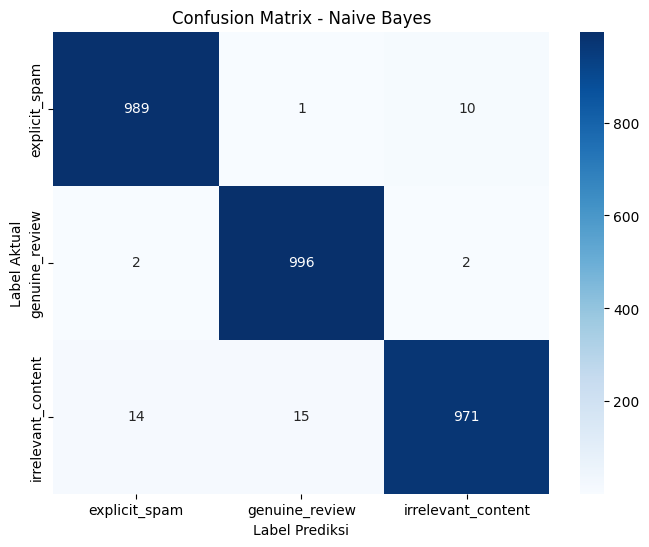


--- Evaluasi untuk Model: SVM ---
Accuracy: 0.9713333333333334

Classification Report:
                    precision    recall  f1-score   support

     explicit_spam       0.99      0.96      0.98      1000
    genuine_review       0.97      0.96      0.97      1000
irrelevant_content       0.95      0.99      0.97      1000

          accuracy                           0.97      3000
         macro avg       0.97      0.97      0.97      3000
      weighted avg       0.97      0.97      0.97      3000


Confusion Matrix:


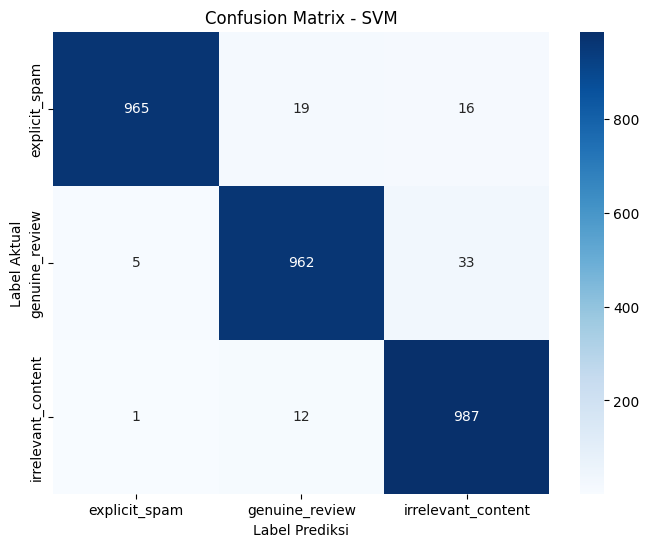


[Tahap 8] Tuning Hyperparameter (TODO)...

[Tahap 9] Penyimpanan Model (TODO)...

--- PIPELINE SELESAI ---

Untuk mengakses hasil (jika dijalankan sebagai skrip utama dan ingin diinspeksi):
df_result berisi DataFrame awal dengan kolom encoded.
models_result adalah dictionary berisi model-model yang sudah dilatih.


In [9]:
if __name__ == "__main__":
    df_result, models_result = run_classification_pipeline()
    # Anda bisa menambahkan kode di sini untuk interaksi lebih lanjut dengan df_result atau models_result
    # jika dijalankan dalam environment interaktif.
    print("\nUntuk mengakses hasil (jika dijalankan sebagai skrip utama dan ingin diinspeksi):")
    print("df_result berisi DataFrame awal dengan kolom encoded.")
    print("models_result adalah dictionary berisi model-model yang sudah dilatih.")